# Settings

In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import optuna

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

def confusion2score(confusion):
    tp, fn, fp, tn = confusion.ravel()
    if tp == None:
        tp = 0
    if fn == None:
        fn = 0
    if fp == None:
        fp = 0
    if tn == None:
        tn = 0
    acc = (tp + tn) / (tp + fn + fp + tn)
    if (tp+fp) == 0:
        pre=0
    else:
        pre = tp / (tp + fp)
    if (tp+fn) == 0:
        rec=0
    else:
        rec = tp / (tp + fn)
    if (2*tp+fp+fn) == 0:
        f1=0
    else:
        f1  = (2 * tp) / (2*tp + fp + fn)
    return (acc, pre, rec, f1)

import spacy
from bs4 import BeautifulSoup

spacy_en = spacy.load('en')
def tokenizer(text):
    soup = BeautifulSoup(text)
    clean_txt = soup.get_text()
    words = []
    for tok in spacy_en.tokenizer(clean_txt):
        if tok.text not in "[],.();:<>{}|*-~":
            words.append(tok.lemma_)
    return " ".join(words)

# Logistic Regression

## without feature engineering

In [2]:
train_df = pd.read_csv('/home/b2018yniki/data/semeval2010task8/train_original.tsv', sep='\t')
train_df = train_df.assign(causal_flag = [0 if 'Cause-Effect' in relation else 1 for relation in train_df.relation.values]).drop(['relation', 'comment'], axis=1)
train_df.body = [text.replace('"', '') for text in train_df.body.values]
test_df = pd.read_csv('/home/b2018yniki/data/semeval2010task8/test_original.tsv', sep='\t')
test_df = test_df.assign(causal_flag = [0 if 'Cause-Effect' in relation else 1 for relation in test_df.relation.values]).drop(['relation', 'comment'], axis=1)
test_df.body = [text.replace('"', '') for text in test_df.body.values]

X_train = [tokenizer(text) for text in train_df.body.values]
X_test  = [tokenizer(text) for text in test_df.body.values]
y_train = train_df.causal_flag.values
y_test  = test_df.causal_flag.values
del train_df, test_df

vect = CountVectorizer(min_df=10, ngram_range=(1,3))
vect.fit(X_train)
X_train = vect.transform(X_train)
X_test  = vect.transform(X_test)

feature_names = vect.get_feature_names()
print("Number of features: {}".format(len(feature_names)))
X_train = pd.DataFrame(X_train.toarray(), columns=feature_names)
X_test  = pd.DataFrame(X_test.toarray(), columns=feature_names)

print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)

lgreg = LogisticRegression(penalty='l2', C=1.0, random_state=2019)
lgreg.fit(X_train, y_train)
y_pred = lgreg.predict(X_test)

confusion = confusion_matrix(y_test, y_pred)
scores    = confusion2score(confusion)
auc       = roc_auc_score(y_test, y_pred)
print('Confusion Matrix: ')
print(confusion)
print('scores: ', scores)
print('AUC: ', auc)

Number of features: 2794
X_train shape:  (8000, 2794)
X_test shape:  (2717, 2794)


/home/b2018yniki/.pyenv/versions/3.7.1/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Confusion Matrix: 
[[ 246   82]
 [  35 2354]]
scores:  (0.9569377990430622, 0.8754448398576512, 0.75, 0.8078817733990148)
AUC:  0.8676747593135202


### with oversampling

In [2]:
def create_model_pred(train_df, test_df, n_gram, min_df, penalty, C):
    X_train = [tokenizer(text) for text in train_df.body.values]
    X_test  = [tokenizer(text) for text in test_df.body.values]
    y_train = train_df.causal_flag.values
    y_test  = test_df.causal_flag.values
    
    vect = CountVectorizer(min_df=min_df, ngram_range=(1,n_gram))
    vect.fit(X_train)
    X_train = vect.transform(X_train)
    X_test  = vect.transform(X_test)
    
    lgreg = LogisticRegression(penalty=penalty, C=C, random_state=2019)
    lgreg.fit(X_train, y_train)
    y_pred = lgreg.predict(X_test)
    
    confusion = confusion_matrix(y_test, y_pred)
    scores    = confusion2score(confusion)
    return scores

train_df = pd.read_csv('/home/b2018yniki/data/semeval2010task8/train_original.tsv', sep='\t')
train_df = train_df.assign(causal_flag = [0 if 'Cause-Effect' in relation else 1 for relation in train_df.relation.values]).drop(['relation', 'comment'], axis=1)
train_df.body = [text.replace('"', '') for text in train_df.body.values]
test_df = pd.read_csv('/home/b2018yniki/data/semeval2010task8/test_original.tsv', sep='\t')
test_df = test_df.assign(causal_flag = [0 if 'Cause-Effect' in relation else 1 for relation in test_df.relation.values]).drop(['relation', 'comment'], axis=1)
test_df.body = [text.replace('"', '') for text in test_df.body.values]

posi_df = train_df[train_df.causal_flag==0]
nega_df = train_df[train_df.causal_flag==1]
train_df = pd.concat([posi_df, posi_df, posi_df, posi_df, posi_df, posi_df, posi_df, nega_df])
del posi_df, nega_df

create_model_pred(train_df, test_df, n_gram=3, min_df=10, penalty='l2', C=1.0)

/home/b2018yniki/.pyenv/versions/3.7.1/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


(0.9620905410379095,
 0.8526645768025078,
 0.8292682926829268,
 0.8408037094281299)

## with feature engineering

In [4]:
train_df = pd.read_csv('/home/b2018yniki/data/semeval2010task8/train_original.tsv', sep='\t')
train_df = train_df.assign(causal_flag = [0 if 'Cause-Effect' in relation else 1 for relation in train_df.relation.values]).drop(['relation', 'comment'], axis=1)
train_df.body = [text.replace('"', '') for text in train_df.body.values]
test_df = pd.read_csv('/home/b2018yniki/data/semeval2010task8/test_original.tsv', sep='\t')
test_df = test_df.assign(causal_flag = [0 if 'Cause-Effect' in relation else 1 for relation in test_df.relation.values]).drop(['relation', 'comment'], axis=1)
test_df.body = [text.replace('"', '') for text in test_df.body.values]

X_train = [tokenizer(text) for text in train_df.body.values]
X_test  = [tokenizer(text) for text in test_df.body.values]
y_train = train_df.causal_flag.values
y_test  = test_df.causal_flag.values
del train_df, test_df

vect = CountVectorizer(min_df=10, ngram_range=(1,3))
vect.fit(X_train)
X_train = vect.transform(X_train)
X_test  = vect.transform(X_test)

feature_names = vect.get_feature_names()
print("Number of features: {}".format(len(feature_names)))
X_train = pd.DataFrame(X_train.toarray(), columns=feature_names)
X_test  = pd.DataFrame(X_test.toarray(), columns=feature_names)

print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)

rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=2019)
rf_model.fit(X_train, y_train)

fi_df = pd.DataFrame(rf_model.feature_importances_, index=feature_names)
use_cols = fi_df[fi_df[0] > 0.0].index.values

print('# of use columns: ', len(use_cols))
X_train = X_train[use_cols]
X_test  = X_test[use_cols]

lgreg = LogisticRegression(penalty='l2', C=1.0, random_state=2019)
lgreg.fit(X_train, y_train)
y_pred = lgreg.predict(X_test)

confusion = confusion_matrix(y_test, y_pred)
scores    = confusion2score(confusion)
auc       = roc_auc_score(y_test, y_pred)
print('Confusion Matrix: ')
print(confusion)
print('scores: ', scores)
print('AUC: ', auc)

Number of features: 2794
X_train shape:  (8000, 2794)
X_test shape:  (2717, 2794)
# of use columns:  1401


/home/b2018yniki/.pyenv/versions/3.7.1/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Confusion Matrix: 
[[ 251   77]
 [  29 2360]]
scores:  (0.9609863820390137, 0.8964285714285715, 0.7652439024390244, 0.8256578947368421)
AUC:  0.876552466079286


## with oversampling

In [5]:
train_df = pd.read_csv('/home/b2018yniki/data/semeval2010task8/train_original.tsv', sep='\t')
train_df = train_df.assign(causal_flag = [0 if 'Cause-Effect' in relation else 1 for relation in train_df.relation.values]).drop(['relation', 'comment'], axis=1)
train_df.body = [text.replace('"', '') for text in train_df.body.values]
test_df = pd.read_csv('/home/b2018yniki/data/semeval2010task8/test_original.tsv', sep='\t')
test_df = test_df.assign(causal_flag = [0 if 'Cause-Effect' in relation else 1 for relation in test_df.relation.values]).drop(['relation', 'comment'], axis=1)
test_df.body = [text.replace('"', '') for text in test_df.body.values]

posi_df = train_df[train_df.causal_flag==0]
nega_df = train_df[train_df.causal_flag==1]

train_df = pd.concat([posi_df, posi_df, posi_df, posi_df, posi_df, posi_df, posi_df, nega_df])
del posi_df, nega_df

X_train = [tokenizer(text) for text in train_df.body.values]
X_test  = [tokenizer(text) for text in test_df.body.values]
y_train = train_df.causal_flag.values
y_test  = test_df.causal_flag.values
del train_df, test_df

vect = CountVectorizer(min_df=10, ngram_range=(1,3))
vect.fit(X_train)
X_train = vect.transform(X_train)
X_test  = vect.transform(X_test)

feature_names = vect.get_feature_names()
print("Number of features: {}".format(len(feature_names)))
X_train = pd.DataFrame(X_train.toarray(), columns=feature_names)
X_test  = pd.DataFrame(X_test.toarray(), columns=feature_names)

print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)

lgreg = LogisticRegression(penalty='l2', C=1.0, random_state=2019)
lgreg.fit(X_train, y_train)
y_pred = lgreg.predict(X_test)

confusion = confusion_matrix(y_test, y_pred)
scores    = confusion2score(confusion)
auc       = roc_auc_score(y_test, y_pred)
print('Confusion Matrix: ')
print(confusion)
print('scores: ', scores)
print('AUC: ', auc)

Number of features: 6407
X_train shape:  (14018, 6407)
X_test shape:  (2717, 6407)


/home/b2018yniki/.pyenv/versions/3.7.1/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Confusion Matrix: 
[[ 272   56]
 [  47 2342]]
scores:  (0.9620905410379095, 0.8526645768025078, 0.8292682926829268, 0.8408037094281299)
AUC:  0.9047973945624763


In [6]:
train_df = pd.read_csv('/home/b2018yniki/data/semeval2010task8/train_original.tsv', sep='\t')
train_df = train_df.assign(causal_flag = [0 if 'Cause-Effect' in relation else 1 for relation in train_df.relation.values]).drop(['relation', 'comment'], axis=1)
train_df.body = [text.replace('"', '') for text in train_df.body.values]
test_df = pd.read_csv('/home/b2018yniki/data/semeval2010task8/test_original.tsv', sep='\t')
test_df = test_df.assign(causal_flag = [0 if 'Cause-Effect' in relation else 1 for relation in test_df.relation.values]).drop(['relation', 'comment'], axis=1)
test_df.body = [text.replace('"', '') for text in test_df.body.values]

posi_df = train_df[train_df.causal_flag==0]
nega_df = train_df[train_df.causal_flag==1]
train_df = pd.concat([posi_df, posi_df, posi_df, posi_df, posi_df, posi_df, posi_df, nega_df])
del posi_df, nega_df

X_train = [tokenizer(text) for text in train_df.body.values]
X_test  = [tokenizer(text) for text in test_df.body.values]
y_train = train_df.causal_flag.values
y_test  = test_df.causal_flag.values
del train_df, test_df

vect = CountVectorizer(min_df=10, ngram_range=(1,3))
vect.fit(X_train)
X_train = vect.transform(X_train)
X_test  = vect.transform(X_test)

feature_names = vect.get_feature_names()
print("Number of features: {}".format(len(feature_names)))
X_train = pd.DataFrame(X_train.toarray(), columns=feature_names)
X_test  = pd.DataFrame(X_test.toarray(), columns=feature_names)

print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)

rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=2019)
rf_model.fit(X_train, y_train)

fi_df = pd.DataFrame(rf_model.feature_importances_, index=feature_names)
use_cols = fi_df[fi_df[0] > 0.0].index.values

print('# of use columns: ', len(use_cols))
X_train = X_train[use_cols]
X_test  = X_test[use_cols]

lgreg = LogisticRegression(penalty='l2', C=1.0, random_state=2019)
lgreg.fit(X_train, y_train)
y_pred = lgreg.predict(X_test)

confusion = confusion_matrix(y_test, y_pred)
scores    = confusion2score(confusion)
auc       = roc_auc_score(y_test, y_pred)
print('Confusion Matrix: ')
print(confusion)
print('scores: ', scores)
print('AUC: ', auc)

Number of features: 6407
X_train shape:  (14018, 6407)
X_test shape:  (2717, 6407)
# of use columns:  2042


/home/b2018yniki/.pyenv/versions/3.7.1/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Confusion Matrix: 
[[ 277   51]
 [  77 2312]]
scores:  (0.9528892160471107, 0.7824858757062146, 0.8445121951219512, 0.8123167155425219)
AUC:  0.9061405680507202


In [2]:
def create_model_pred2(train_df, test_df, n_gram, min_df, penalty, C, feat_eng=False):
    X_train = [tokenizer(text) for text in train_df.body.values]
    X_test  = [tokenizer(text) for text in test_df.body.values]
    y_train = train_df.causal_flag.values
    y_test  = test_df.causal_flag.values
    
    vect = CountVectorizer(min_df=min_df, ngram_range=(1,n_gram))
    vect.fit(X_train)
    X_train = vect.transform(X_train)
    X_test  = vect.transform(X_test)
    
    if feat_eng:
        rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=2019)
        rf_model.fit(X_train, y_train)
        feature_names = vect.get_feature_names()
        X_train = pd.DataFrame(X_train.toarray(), columns=feature_names)
        X_test  = pd.DataFrame(X_test.toarray(), columns=feature_names)
        fi_df = pd.DataFrame(rf_model.feature_importances_, index=feature_names)
        use_cols = fi_df[fi_df[0] > 0.0].index.values
        X_train = X_train[use_cols]
        X_test  = X_test[use_cols]
    lgreg = LogisticRegression(penalty=penalty, C=C, random_state=2019)
    lgreg.fit(X_train, y_train)
    y_pred = lgreg.predict(X_test)
    
    confusion = confusion_matrix(y_test, y_pred)
    scores    = confusion2score(confusion)
    return scores

train_df = pd.read_csv('/home/b2018yniki/data/semeval2010task8/train_original.tsv', sep='\t')
train_df = train_df.assign(causal_flag = [0 if 'Cause-Effect' in relation else 1 for relation in train_df.relation.values]).drop(['relation', 'comment'], axis=1)
train_df.body = [text.replace('"', '') for text in train_df.body.values]
test_df = pd.read_csv('/home/b2018yniki/data/semeval2010task8/test_original.tsv', sep='\t')
test_df = test_df.assign(causal_flag = [0 if 'Cause-Effect' in relation else 1 for relation in test_df.relation.values]).drop(['relation', 'comment'], axis=1)
test_df.body = [text.replace('"', '') for text in test_df.body.values]

posi_df = train_df[train_df.causal_flag==0]
nega_df = train_df[train_df.causal_flag==1]
train_df = pd.concat([posi_df, posi_df, posi_df, posi_df, posi_df, posi_df, posi_df, nega_df])
del posi_df, nega_df

create_model_pred(train_df, test_df, n_gram=3, min_df=10, penalty='l2', C=1.0, feat_eng=True)

/home/b2018yniki/.pyenv/versions/3.7.1/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


(0.9528892160471107,
 0.7824858757062146,
 0.8445121951219512,
 0.8123167155425219)

# Hyperparameter Search by Optuna

## without feature engineering

### without oversampling

In [4]:
train_df = pd.read_csv('/home/b2018yniki/data/semeval2010task8/train_original.tsv', sep='\t')
train_df = train_df.assign(causal_flag = [0 if 'Cause-Effect' in relation else 1 for relation in train_df.relation.values]).drop(['relation', 'comment'], axis=1)
train_df.body = [text.replace('"', '') for text in train_df.body.values]
test_df = pd.read_csv('/home/b2018yniki/data/semeval2010task8/test_original.tsv', sep='\t')
test_df = test_df.assign(causal_flag = [0 if 'Cause-Effect' in relation else 1 for relation in test_df.relation.values]).drop(['relation', 'comment'], axis=1)
test_df.body = [text.replace('"', '') for text in test_df.body.values]

def objective(trial):
    n_gram  = trial.suggest_int('n_gram', 1, 6)
    min_df  = int(trial.suggest_discrete_uniform('min_df', 5, 20, 5))
    C       = trial.suggest_loguniform('C', 1e-2, 100)
    penalty = trial.suggest_categorical('penalty', ['l2', 'l1'])
    
    scores = create_model_pred(train_df, test_df, n_gram, min_df, penalty, C)
    
    return 1 - scores[3]

study = optuna.create_study()
study.optimize(objective, n_trials=100)

/home/b2018yniki/.pyenv/versions/3.7.1/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
[I 2019-08-04 11:42:13,952] Finished trial#0 resulted in value: 0.2513562386980108. Current best value is 0.2513562386980108 with parameters: {'n_gram': 4, 'min_df': 20.0, 'C': 0.06115857796370338, 'penalty': 'l1'}.
/home/b2018yniki/.pyenv/versions/3.7.1/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
[I 2019-08-04 11:42:17,854] Finished trial#1 resulted in value: 0.2857142857142857. Current best value is 0.2513562386980108 with parameters: {'n_gram': 4, 'min_df': 20.0, 'C': 0.06115857796370338, 'penalty': 'l1'}.
/home/b2018yniki/.pyenv/versions/3.7.1/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: Fut

In [5]:
print('best parameters: ', study.best_params)
print('best f1 score: {}'.format(1-study.best_value))

best parameters:  {'n_gram': 2, 'min_df': 5.0, 'C': 1.1161545109478617, 'penalty': 'l1'}
best f1 score: 0.8231511254019293


In [6]:
train_df = pd.read_csv('/home/b2018yniki/data/semeval2010task8/train_original.tsv', sep='\t')
train_df = train_df.assign(causal_flag = [0 if 'Cause-Effect' in relation else 1 for relation in train_df.relation.values]).drop(['relation', 'comment'], axis=1)
train_df.body = [text.replace('"', '') for text in train_df.body.values]
test_df = pd.read_csv('/home/b2018yniki/data/semeval2010task8/test_original.tsv', sep='\t')
test_df = test_df.assign(causal_flag = [0 if 'Cause-Effect' in relation else 1 for relation in test_df.relation.values]).drop(['relation', 'comment'], axis=1)
test_df.body = [text.replace('"', '') for text in test_df.body.values]

X_train = [tokenizer(text) for text in train_df.body.values]
X_test  = [tokenizer(text) for text in test_df.body.values]
y_train = train_df.causal_flag.values
y_test  = test_df.causal_flag.values

vect = CountVectorizer(min_df=5, ngram_range=(1,2))
vect.fit(X_train)
X_train = vect.transform(X_train)
X_test  = vect.transform(X_test)

feature_names = vect.get_feature_names()
print("Number of features: {}".format(len(feature_names)))
X_train = pd.DataFrame(X_train.toarray(), columns=feature_names)
X_test  = pd.DataFrame(X_test.toarray(), columns=feature_names)

print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)

lgreg = LogisticRegression(penalty='l1', C=1.0, random_state=2019)
lgreg.fit(X_train, y_train)
y_pred = lgreg.predict(X_test)

confusion = confusion_matrix(y_test, y_pred)
scores    = confusion2score(confusion)
auc       = roc_auc_score(y_test, y_pred)
print('Confusion Matrix: ')
print(confusion)
print('scores: ', scores)
print('AUC: ', auc)

Number of features: 5846
X_train shape:  (8000, 5846)
X_test shape:  (2717, 5846)


/home/b2018yniki/.pyenv/versions/3.7.1/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Confusion Matrix: 
[[ 253   75]
 [  37 2352]]
scores:  (0.9587780640412219, 0.8724137931034482, 0.7713414634146342, 0.8187702265372169)
AUC:  0.8779269058387529


findfont: Font family ['TakaoPGothic'] not found. Falling back to DejaVu Sans.


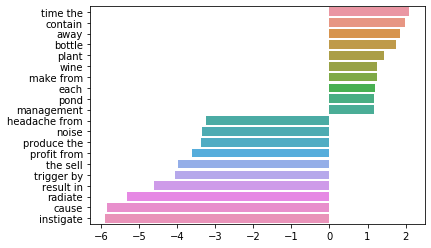

In [8]:
logreg_coef_df = pd.DataFrame(lgreg.coef_.T, index=feature_names, columns=['logreg_coef']).sort_values('logreg_coef', ascending=False)
plot_df = pd.concat([logreg_coef_df.head(10), logreg_coef_df.tail(10)])
plt.figure()
sns.barplot(x=plot_df.logreg_coef.values, y=plot_df.index.values, data=plot_df.head(10))
plt.show()

### with oversampling

In [9]:
train_df = pd.read_csv('/home/b2018yniki/data/semeval2010task8/train_original.tsv', sep='\t')
train_df = train_df.assign(causal_flag = [0 if 'Cause-Effect' in relation else 1 for relation in train_df.relation.values]).drop(['relation', 'comment'], axis=1)
train_df.body = [text.replace('"', '') for text in train_df.body.values]
test_df = pd.read_csv('/home/b2018yniki/data/semeval2010task8/test_original.tsv', sep='\t')
test_df = test_df.assign(causal_flag = [0 if 'Cause-Effect' in relation else 1 for relation in test_df.relation.values]).drop(['relation', 'comment'], axis=1)
test_df.body = [text.replace('"', '') for text in test_df.body.values]

posi_df = train_df[train_df.causal_flag==0]
nega_df = train_df[train_df.causal_flag==1]
train_df = pd.concat([posi_df, posi_df, posi_df, posi_df, posi_df, posi_df, posi_df, nega_df])
del posi_df, nega_df

def objective(trial):
    n_gram  = trial.suggest_int('n_gram', 1, 6)
    min_df  = int(trial.suggest_discrete_uniform('min_df', 5, 20, 5))
    C       = trial.suggest_loguniform('C', 1e-2, 100)
    penalty = trial.suggest_categorical('penalty', ['l2', 'l1'])
    
    scores = create_model_pred(train_df, test_df, n_gram, min_df, penalty, C)
    
    return 1 - scores[3]

study = optuna.create_study()
study.optimize(objective, n_trials=100)

/home/b2018yniki/.pyenv/versions/3.7.1/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
[I 2019-08-04 11:54:27,091] Finished trial#0 resulted in value: 0.1707317073170732. Current best value is 0.1707317073170732 with parameters: {'n_gram': 5, 'min_df': 5.0, 'C': 2.5143305316339677, 'penalty': 'l1'}.
/home/b2018yniki/.pyenv/versions/3.7.1/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
[I 2019-08-04 11:54:33,613] Finished trial#1 resulted in value: 0.1630094043887147. Current best value is 0.1630094043887147 with parameters: {'n_gram': 4, 'min_df': 10.0, 'C': 1.8209509782923528, 'penalty': 'l2'}.
/home/b2018yniki/.pyenv/versions/3.7.1/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: Future

In [10]:
print('best parameters: ', study.best_params)
print('best f1 score: {}'.format(1-study.best_value))

best parameters:  {'n_gram': 2, 'min_df': 5.0, 'C': 0.13772940916303658, 'penalty': 'l2'}
best f1 score: 0.842443729903537


In [4]:
train_df = pd.read_csv('/home/b2018yniki/data/semeval2010task8/train_original.tsv', sep='\t')
train_df = train_df.assign(causal_flag = [0 if 'Cause-Effect' in relation else 1 for relation in train_df.relation.values]).drop(['relation', 'comment'], axis=1)
train_df.body = [text.replace('"', '') for text in train_df.body.values]
test_df = pd.read_csv('/home/b2018yniki/data/semeval2010task8/test_original.tsv', sep='\t')
test_df = test_df.assign(causal_flag = [0 if 'Cause-Effect' in relation else 1 for relation in test_df.relation.values]).drop(['relation', 'comment'], axis=1)
test_df.body = [text.replace('"', '') for text in test_df.body.values]

posi_df = train_df[train_df.causal_flag==0]
nega_df = train_df[train_df.causal_flag==1]
train_df = pd.concat([posi_df, posi_df, posi_df, posi_df, posi_df, posi_df, posi_df, nega_df])
del posi_df, nega_df

X_train = [tokenizer(text) for text in train_df.body.values]
X_test  = [tokenizer(text) for text in test_df.body.values]
y_train = train_df.causal_flag.values
y_test  = test_df.causal_flag.values

vect = CountVectorizer(min_df=5, ngram_range=(1,2))
vect.fit(X_train)
X_train = vect.transform(X_train)
X_test  = vect.transform(X_test)

feature_names = vect.get_feature_names()
print("Number of features: {}".format(len(feature_names)))
X_train = pd.DataFrame(X_train.toarray(), columns=feature_names)
X_test  = pd.DataFrame(X_test.toarray(), columns=feature_names)

print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)

lgreg = LogisticRegression(penalty='l2', C=0.1, random_state=2019)
lgreg.fit(X_train, y_train)
y_pred = lgreg.predict(X_test)

confusion = confusion_matrix(y_test, y_pred)
scores    = confusion2score(confusion)
auc       = roc_auc_score(y_test, y_pred)
print('Confusion Matrix: ')
print(confusion)
print('scores: ', scores)
print('AUC: ', auc)

Number of features: 19000
X_train shape:  (14018, 19000)
X_test shape:  (2717, 19000)


/home/b2018yniki/.pyenv/versions/3.7.1/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Confusion Matrix: 
[[ 262   66]
 [  33 2356]]
scores:  (0.9635627530364372, 0.888135593220339, 0.7987804878048781, 0.841091492776886)
AUC:  0.892483588398044


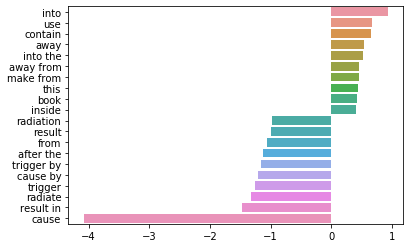

In [5]:
logreg_coef_df = pd.DataFrame(lgreg.coef_.T, index=feature_names, columns=['logreg_coef']).sort_values('logreg_coef', ascending=False)
plot_df = pd.concat([logreg_coef_df.head(10), logreg_coef_df.tail(10)])
plt.figure()
sns.barplot(x=plot_df.logreg_coef.values, y=plot_df.index.values, data=plot_df.head(10))
plt.show()

## with feature engineering

### without oversampling

In [4]:
train_df = pd.read_csv('/home/b2018yniki/data/semeval2010task8/train_original.tsv', sep='\t')
train_df = train_df.assign(causal_flag = [0 if 'Cause-Effect' in relation else 1 for relation in train_df.relation.values]).drop(['relation', 'comment'], axis=1)
train_df.body = [text.replace('"', '') for text in train_df.body.values]
test_df = pd.read_csv('/home/b2018yniki/data/semeval2010task8/test_original.tsv', sep='\t')
test_df = test_df.assign(causal_flag = [0 if 'Cause-Effect' in relation else 1 for relation in test_df.relation.values]).drop(['relation', 'comment'], axis=1)
test_df.body = [text.replace('"', '') for text in test_df.body.values]

def objective(trial):
    n_gram  = trial.suggest_int('n_gram', 1, 6)
    min_df  = int(trial.suggest_discrete_uniform('min_df', 5, 20, 5))
    C       = trial.suggest_loguniform('C', 1e-2, 100)
    penalty = trial.suggest_categorical('penalty', ['l2', 'l1'])
    feat_eng= trial.suggest_categorical('feat_eng', [True, False])
    
    scores = create_model_pred2(train_df, test_df, n_gram, min_df, penalty, C, feat_eng)
    
    return 1 - scores[3]

study = optuna.create_study()
study.optimize(objective, n_trials=100)

print('best parameters: ', study.best_params)
print('best f1 score: {}'.format(1-study.best_value))

/home/b2018yniki/.pyenv/versions/3.7.1/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
[I 2019-07-30 22:27:27,741] Finished trial#0 resulted in value: 0.17434210526315785. Current best value is 0.17434210526315785 with parameters: {'n_gram': 3, 'min_df': 5.0, 'C': 0.5231429867306124, 'penalty': 'l1', 'feat_eng': False}.
/home/b2018yniki/.pyenv/versions/3.7.1/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
[I 2019-07-30 22:27:32,548] Finished trial#1 resulted in value: 0.36254980079681276. Current best value is 0.17434210526315785 with parameters: {'n_gram': 3, 'min_df': 5.0, 'C': 0.5231429867306124, 'penalty': 'l1', 'feat_eng': False}.
/home/b2018yniki/.pyenv/versions/3.7.1/lib/python3.7/site-packages/skl

best parameters:  {'n_gram': 4, 'min_df': 5.0, 'C': 1.9686653741754054, 'penalty': 'l1', 'feat_eng': True}
best f1 score: 0.8412698412698413


### scores of best parameters

In [6]:
train_df = pd.read_csv('/home/b2018yniki/data/semeval2010task8/train_original.tsv', sep='\t')
train_df = train_df.assign(causal_flag = [0 if 'Cause-Effect' in relation else 1 for relation in train_df.relation.values]).drop(['relation', 'comment'], axis=1)
train_df.body = [text.replace('"', '') for text in train_df.body.values]
test_df = pd.read_csv('/home/b2018yniki/data/semeval2010task8/test_original.tsv', sep='\t')
test_df = test_df.assign(causal_flag = [0 if 'Cause-Effect' in relation else 1 for relation in test_df.relation.values]).drop(['relation', 'comment'], axis=1)
test_df.body = [text.replace('"', '') for text in test_df.body.values]

X_train = [tokenizer(text) for text in train_df.body.values]
X_test  = [tokenizer(text) for text in test_df.body.values]
y_train = train_df.causal_flag.values
y_test  = test_df.causal_flag.values

vect = CountVectorizer(min_df=5, ngram_range=(1,4))
vect.fit(X_train)
X_train = vect.transform(X_train)
X_test  = vect.transform(X_test)

feature_names = vect.get_feature_names()
print("Number of features: {}".format(len(feature_names)))
X_train = pd.DataFrame(X_train.toarray(), columns=feature_names)
X_test  = pd.DataFrame(X_test.toarray(), columns=feature_names)

print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)

rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=2019)
rf_model.fit(X_train, y_train)

fi_df = pd.DataFrame(rf_model.feature_importances_, index=feature_names)
use_cols = fi_df[fi_df[0] > 0.0].index.values

print('# of use columns: ', len(use_cols))
X_train = X_train[use_cols]
X_test  = X_test[use_cols]

lgreg = LogisticRegression(penalty='l1', C=1.9686653741754054, random_state=2019)
lgreg.fit(X_train, y_train)
y_pred = lgreg.predict(X_test)

confusion = confusion_matrix(y_test, y_pred)
scores    = confusion2score(confusion)
auc       = roc_auc_score(y_test, y_pred)
print('Confusion Matrix: ')
print(confusion)
print('scores: ', scores)
print('AUC: ', auc)

Number of features: 6536
X_train shape:  (8000, 6536)
X_test shape:  (2717, 6536)
# of use columns:  1498


/home/b2018yniki/.pyenv/versions/3.7.1/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Confusion Matrix: 
[[ 265   63]
 [  37 2352]]
scores:  (0.9631947000368053, 0.8774834437086093, 0.8079268292682927, 0.8412698412698413)
AUC:  0.896219588765582


findfont: Font family ['TakaoPGothic'] not found. Falling back to DejaVu Sans.


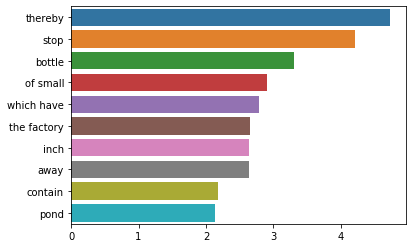

In [9]:
logreg_coef_df = pd.DataFrame(lgreg.coef_.T, index=use_cols, columns=['logreg_coef']).sort_values('logreg_coef', ascending=False)
plt.figure()
sns.barplot(x=logreg_coef_df.head(10).logreg_coef.values, y=logreg_coef_df.head(10).index.values, data=logreg_coef_df.head(10))
plt.show()

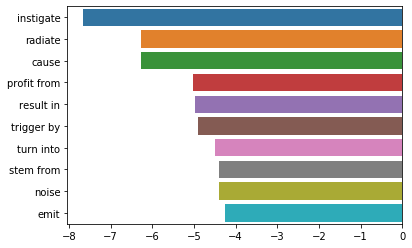

In [10]:
logreg_coef_df = logreg_coef_df.sort_values('logreg_coef', ascending=True)
plt.figure()
sns.barplot(x=logreg_coef_df.head(10).logreg_coef.values, y=logreg_coef_df.head(10).index.values, data=logreg_coef_df.head(10))
plt.show()

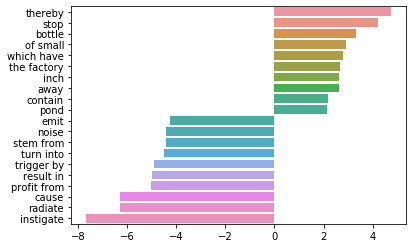

In [12]:
logreg_coef_df = pd.DataFrame(lgreg.coef_.T, index=use_cols, columns=['logreg_coef']).sort_values('logreg_coef', ascending=False)
plot_df = pd.concat([logreg_coef_df.head(10), logreg_coef_df.tail(10)])
plt.figure()
sns.barplot(x=plot_df.logreg_coef.values, y=plot_df.index.values, data=plot_df.head(10))
plt.show()

### with oversampling

In [13]:
train_df = pd.read_csv('/home/b2018yniki/data/semeval2010task8/train_original.tsv', sep='\t')
train_df = train_df.assign(causal_flag = [0 if 'Cause-Effect' in relation else 1 for relation in train_df.relation.values]).drop(['relation', 'comment'], axis=1)
train_df.body = [text.replace('"', '') for text in train_df.body.values]
test_df = pd.read_csv('/home/b2018yniki/data/semeval2010task8/test_original.tsv', sep='\t')
test_df = test_df.assign(causal_flag = [0 if 'Cause-Effect' in relation else 1 for relation in test_df.relation.values]).drop(['relation', 'comment'], axis=1)
test_df.body = [text.replace('"', '') for text in test_df.body.values]

posi_df = train_df[train_df.causal_flag==0]
nega_df = train_df[train_df.causal_flag==1]
train_df = pd.concat([posi_df, posi_df, posi_df, posi_df, posi_df, posi_df, posi_df, nega_df])
del posi_df, nega_df

def objective(trial):
    n_gram  = trial.suggest_int('n_gram', 1, 6)
    min_df  = int(trial.suggest_discrete_uniform('min_df', 5, 20, 5))
    C       = trial.suggest_loguniform('C', 1e-2, 100)
    penalty = trial.suggest_categorical('penalty', ['l2', 'l1'])
    feat_eng= trial.suggest_categorical('feat_eng', [True, False])
    
    scores = create_model_pred2(train_df, test_df, n_gram, min_df, penalty, C, feat_eng)
    
    return 1 - scores[3]

study = optuna.create_study()
study.optimize(objective, n_trials=100)

print('best parameters: ', study.best_params)
print('best f1 score: {}'.format(1-study.best_value))

/home/b2018yniki/.pyenv/versions/3.7.1/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
[I 2019-07-30 22:53:24,345] Finished trial#0 resulted in value: 0.24295302013422815. Current best value is 0.24295302013422815 with parameters: {'n_gram': 3, 'min_df': 5.0, 'C': 0.08326121871116524, 'penalty': 'l1', 'feat_eng': True}.
/home/b2018yniki/.pyenv/versions/3.7.1/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
[I 2019-07-30 22:53:31,378] Finished trial#1 resulted in value: 0.21468926553672318. Current best value is 0.21468926553672318 with parameters: {'n_gram': 3, 'min_df': 15.0, 'C': 0.32574966028227087, 'penalty': 'l1', 'feat_eng': True}.
/home/b2018yniki/.pyenv/versions/3.7.1/lib/python3.7/site-packages/sk

best parameters:  {'n_gram': 2, 'min_df': 15.0, 'C': 1.6428142803878487, 'penalty': 'l2', 'feat_eng': False}
best f1 score: 0.8295625942684767


In [14]:
train_df = pd.read_csv('/home/b2018yniki/data/semeval2010task8/train_original.tsv', sep='\t')
train_df = train_df.assign(causal_flag = [0 if 'Cause-Effect' in relation else 1 for relation in train_df.relation.values]).drop(['relation', 'comment'], axis=1)
train_df.body = [text.replace('"', '') for text in train_df.body.values]
test_df = pd.read_csv('/home/b2018yniki/data/semeval2010task8/test_original.tsv', sep='\t')
test_df = test_df.assign(causal_flag = [0 if 'Cause-Effect' in relation else 1 for relation in test_df.relation.values]).drop(['relation', 'comment'], axis=1)
test_df.body = [text.replace('"', '') for text in test_df.body.values]

posi_df = train_df[train_df.causal_flag==0]
nega_df = train_df[train_df.causal_flag==1]
train_df = pd.concat([posi_df, posi_df, posi_df, posi_df, posi_df, posi_df, posi_df, nega_df])
del posi_df, nega_df

X_train = [tokenizer(text) for text in train_df.body.values]
X_test  = [tokenizer(text) for text in test_df.body.values]
y_train = train_df.causal_flag.values
y_test  = test_df.causal_flag.values

vect = CountVectorizer(min_df=15, ngram_range=(1,2))
vect.fit(X_train)
X_train = vect.transform(X_train)
X_test  = vect.transform(X_test)

feature_names = vect.get_feature_names()
print("Number of features: {}".format(len(feature_names)))
X_train = pd.DataFrame(X_train.toarray(), columns=feature_names)
X_test  = pd.DataFrame(X_test.toarray(), columns=feature_names)

print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)

lgreg = LogisticRegression(penalty='l2', C=1.6428142803878487, random_state=2019)
lgreg.fit(X_train, y_train)
y_pred = lgreg.predict(X_test)

confusion = confusion_matrix(y_test, y_pred)
scores    = confusion2score(confusion)
auc       = roc_auc_score(y_test, y_pred)
print('Confusion Matrix: ')
print(confusion)
print('scores: ', scores)
print('AUC: ', auc)

Number of features: 3648
X_train shape:  (14018, 3648)
X_test shape:  (2717, 3648)


/home/b2018yniki/.pyenv/versions/3.7.1/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Confusion Matrix: 
[[ 275   53]
 [  60 2329]]
scores:  (0.95841001104159, 0.8208955223880597, 0.8384146341463414, 0.8295625942684767)
AUC:  0.9066497616106342


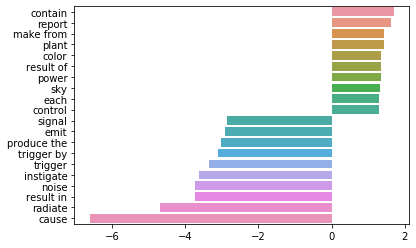

In [16]:
logreg_coef_df = pd.DataFrame(lgreg.coef_.T, index=feature_names, columns=['logreg_coef']).sort_values('logreg_coef', ascending=False)
plot_df = pd.concat([logreg_coef_df.head(10), logreg_coef_df.tail(10)])
plt.figure()
sns.barplot(x=plot_df.logreg_coef.values, y=plot_df.index.values, data=plot_df.head(10))
plt.show()